In [1]:
# 导入模块并创建实例
import requests
import json
import os
from diophila import OpenAlex
openalex = OpenAlex()

In [2]:
# 确定搜索内容并生成json文件
search_name = 'meta analysis'
for year in range(2000, 2025):
    filters = {"is_oa": "true",
            "type": "review",
            "publication_year": year,
            }

    grouped_concepts_list = openalex.get_list_of_works(search=search_name,pages=[i for i in range(1, 2)],filters=filters)
    # grouped_concepts_list = openalex.get_list_of_works(search=search_name,pages=[1,20])

    # 收集生成器中的所有数据
    concepts_list = list(grouped_concepts_list)
 
    # 设置文件夹名称
    folder_name = 'tmp/' + search_name

    # 检查文件夹路径是否存在，如果不存在则创建
    folder_path = os.path.join('.', folder_name)  # 当前目录下创建文件夹
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # 保存的文件名
    save_file_name = os.path.join(folder_path, search_name + str(year) + '.json')

    # 将数据转换为JSON格式并保存到文件
    with open(save_file_name, 'w', encoding='utf-8') as f:
        json.dump(concepts_list, f, ensure_ascii=False, indent=4)

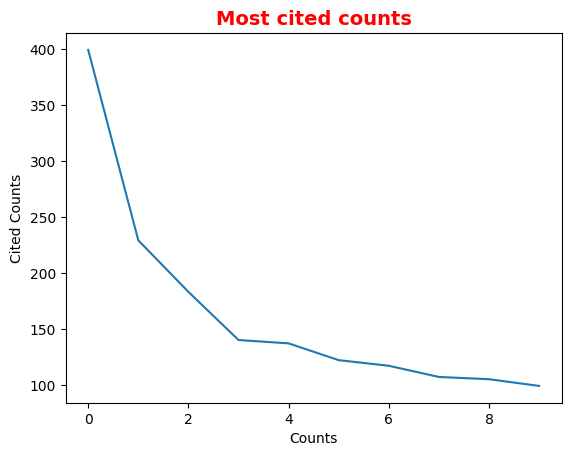

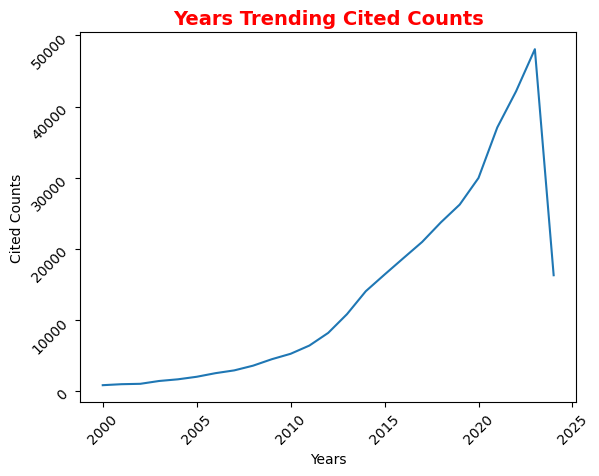

In [4]:
# 对json文件进行处理（筛选和过滤）,并根据引用量进行排序
# 文章的主要meta信息，保留作者信息，机构信息
import matplotlib.pyplot as plt
unprocessed_json_file_path = './tmp/' + search_name + '/' + 'meta analysis2023.json'
def process_origin_json_file(json_file_path):
    
    with open(json_file_path, 'r', encoding='utf-8') as file:
        unprocessed_json_file = json.load(file)

    processed_info = []
    num = 10
    for single_meta in unprocessed_json_file:
        single_meta_page = single_meta['meta']['page']

        for single_article_info in single_meta['results']:
            cited_count = single_article_info['cited_by_count']
            authorships_info = single_article_info['authorships']
            id = single_article_info['id']
            doi = single_article_info['doi']
            title = single_article_info['title']

            processed_info.append([cited_count, authorships_info, id, doi, title])

    processed_info.sort(key=lambda x: x[0], reverse=True)

    most_cited_list = []
    most_cited_info = processed_info[:min(len(processed_info), num)]
    for i in range(min(len(processed_info), num)):
        most_cited_list.append(processed_info[i][0])

    # print(most_cited_list)
    plt.plot(most_cited_list)
    plt.title('Most cited counts', fontsize=14, fontweight='bold', color='red')
    plt.xlabel('Counts')
    plt.ylabel('Cited Counts')
    plt.show()

directory = './tmp/' + search_name
def draw_years_trending(directory):
    count_list = []
    year_list = []
    # 遍历目录下的所有文件和子目录
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                # 构造文件的完整路径
                file_path = os.path.join(root, file)
                # 对JSON文件进行操作
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    # print(file[-9:-5])
                    year = int(file[-9:-5])
                    # count_list.append(data[0]['meta']['count'])
                    # year_list.append(year)
                    count_list.append([data[0]['meta']['count'], year])

    
    count_list.sort(key=lambda x:x[1])
    x_array = []
    y_array = []
    for i in range(len(count_list)):
        
        y_array.append(count_list[i][0])
        x_array.append(count_list[i][1])

    plt.plot(x_array, y_array)
    plt.title('Years Trending Cited Counts', fontsize=14, fontweight='bold', color='red')
    plt.xlabel('Years')
    plt.ylabel('Cited Counts')
    plt.xticks(rotation=45)  # 旋转x轴标签45度
    plt.yticks(rotation=45)  # 旋转y轴标签45度
    # plt.tight_layout()
    plt.show()

process_origin_json_file(unprocessed_json_file_path)
draw_years_trending(directory)

        

In [5]:
from openai import OpenAI
client = OpenAI()
 
assistant = client.beta.assistants.create(
  instructions="You are a weather bot. Use the provided functions to answer questions.",
  model="gpt-4o",
  tools=[
    {
      "type": "function",
      "function": {
        "name": "get_current_temperature",
        "description": "Get the current temperature for a specific location",
        "parameters": {
          "type": "object",
          "properties": {
            "location": {
              "type": "string",
              "description": "The city and state, e.g., San Francisco, CA"
            },
            "unit": {
              "type": "string",
              "enum": ["Celsius", "Fahrenheit"],
              "description": "The temperature unit to use. Infer this from the user's location."
            }
          },
          "required": ["location", "unit"]
        }
      }
    },
    {
      "type": "function",
      "function": {
        "name": "get_rain_probability",
        "description": "Get the probability of rain for a specific location",
        "parameters": {
          "type": "object",
          "properties": {
            "location": {
              "type": "string",
              "description": "The city and state, e.g., San Francisco, CA"
            }
          },
          "required": ["location"]
        }
      }
    }
  ]
)
thread = client.beta.threads.create()
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="What's the weather in San Francisco today and the likelihood it'll rain?",
)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable